# Verification of the train dataset

Imports and data loading

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_jsonl_df(jsonl_file, lab=False):
    user_contents = []
    assistant_contents = []
    labels = []

    with open(jsonl_file, 'r') as file:
        for line in file:
            data = json.loads(line)
            message = data['messages']
            user_contents.append(message[0]['content'])
            assistant_contents.append(message[1]['content'])
            if lab == True:
                labels.append(data['target'])


    if lab == True:
        df = pd.DataFrame({
            'user_content': user_contents,
            'assistant_content': assistant_contents,
            'target' : labels
            })
    else:
        df = pd.DataFrame({
            'user_content': user_contents,
            'assistant_content': assistant_contents
            })
    return df

In [77]:
data_lab = load_jsonl_df('dataset/train_dataset_lab.jsonl', lab=True)
data_lab.shape

(1000, 3)

In [80]:
data_lab.head()

,user_content,assistant_content,target
0,"List of genes : <<< B3GAT2,FUT4,POMGNT2 >>>\nL...",The experiment identified the Mannose type O-g...,Mannose type O-glycan biosynthesis
1,"List of genes : <<< ACOX3,PLA2G12A,PLAAT2,PLA2...",The metabolic pathway identified in this exper...,alpha-Linolenic acid metabolism
2,"List of genes : <<< HADHB,ELOVL1,THEM5,ELOVL3,...",Based on the provided list of genes and compou...,Fatty acid elongation
3,"List of genes : <<< EHHADH,OXCT1 >>>\nList of ...",The metabolic pathway identified in the experi...,Butanoate metabolism
4,"List of genes : <<< IDH1,PKM,SHMT1,SDS >>>\nLi...",The metabolic pathway identified in the experi...,Biosynthesis of amino acids


## Pathway in assistant response is the right one

In [68]:
def verify_response(row):
    if row.iloc[2].lower() in row.iloc[1].lower():
        return True
    else:
        return False

In [69]:
data_lab['Correct'] = data_lab.apply(verify_response, axis=1)

In [70]:
data_lab["Correct"].value_counts()

Correct
True     952
False     48
Name: count, dtype: int64

In [71]:
def print_cells(row):
    print(row.iloc[2])
    print(row.iloc[1] + '\n\n')

In [72]:
data_lab.loc[data_lab["Correct"] == False].apply(print_cells, axis=1)

Glycosaminoglycan biosynthesis - heparan sulfate / heparin
The metabolic pathway identified in this comparison is the Glycosaminoglycan biosynthesis - heparan sulfate/heparin pathway. This pathway was implicated due to the alterations in genes such as B3GAT3, HS3ST3A1, HS6ST1, GLCE, EXTL2, B3GALT6, HS6ST3, NDST1, NDST4, HS6ST2, EXT2, B4GALT7, and XYLT2. These genes are known to encode enzymes involved in the biosynthesis of heparan sulfate/heparin, a type of glycosaminoglycan. The presence of [Protein]-L-serine and Adenosine 3',5'-bisphosphate, which are known intermediates in this pathway, further supports this identification. Acetate, although not directly involved in this pathway, can indirectly affect it by contributing to the acetyl-CoA pool, which is necessary for the synthesis of glycosaminoglycans. Thus, the alterations in these genes and compounds suggest a dysregulation in the Glycosaminoglycan biosynthesis - heparan sulfate/heparin pathway.


Valine, leucine and isoleucine b

9      None
16     None
27     None
50     None
88     None
110    None
113    None
121    None
128    None
141    None
142    None
146    None
150    None
176    None
182    None
188    None
205    None
220    None
233    None
243    None
245    None
250    None
253    None
254    None
266    None
298    None
337    None
389    None
502    None
508    None
518    None
618    None
638    None
648    None
662    None
678    None
680    None
682    None
699    None
741    None
797    None
809    None
856    None
864    None
909    None
914    None
918    None
998    None
dtype: object

After checking the 21 incorrect lines, it seems that differences occured because of addition/suppression of special characters in pathway names.
Besides this, all assistant responses were correct.

In [ ]:
data_lab = data_lab.drop("Correct", axis=1)
data_lab.shape

## Representation of each pathway

Iter1 : The representation of some pathways seems a little imbalanced, especially for pathway that are quite specific (Neomycin, kanamycin and gentamicin biosynthesis, Caffeine metabolism). Some pathways still have only one representation, highlighting the need for further generation. New generation was performed excluding these 2 pathways

Iter2 : The representation is still quite imbalanced. Running new generation with only the pathways with less than 4 examples. Excluding pathway which to my knowledge are not very specific or quite rare.

Iter3 : After first fine-tuning attempt, I understand that I do not have enough data, so decided to generate more by implementing a method to make the model generate at least 10 examples per pathway. For that I already need the list of pathway codes and the count of examples (dict {pathwaycode : exemple_count}

In [73]:
keggdf = pd.read_json('prompts/pathway_genes_compoundsrf.json', orient='index')
keggdf.head()

,name,genes,compounds
hsa01200,Carbon metabolism,"[ME3, SDS, SDSL, , ADH5, GLYCTK, CPS1, GOT1L1,...","[D-Fructose 6-phosphate, D-Ribulose 1,5-bispho..."
hsa01210,2-Oxocarboxylic acid metabolism,"[ABHD14A-ACY1, GOT1L1, CS, NAGS, DBT, DLAT, DL...","[8-Methylthiooctyl glucosinolate, 2-Oxo-10-met..."
hsa01212,Fatty acid metabolism,"[ACAA2, HTD2, CPT1C, CPT1A, CPT1B, CPT2, ECHS1...","[Acetyl-CoA, Acetyl-[acyl-carrier protein], Ac..."
hsa01230,Biosynthesis of amino acids,"[ABHD14A-ACY1, , SDS, SDSL, CPS1, GOT1L1, CS, ...","[N6-Acetyl-LL-2,6-diaminoheptanedioate, (Z)-Bu..."
hsa01232,Nucleotide metabolism,"[ADA, NT5C1B-RDH14, NME6, AK6, NT5C3B, AK7, AD...","[IMP, IDP, ITP, AMP, ADP, ATP, Inosine, Adenos..."


In [74]:
pd.set_option('display.max_rows', 99)
vc = data_lab['target'].value_counts().to_dict()


<BarContainer object of 88 artists>

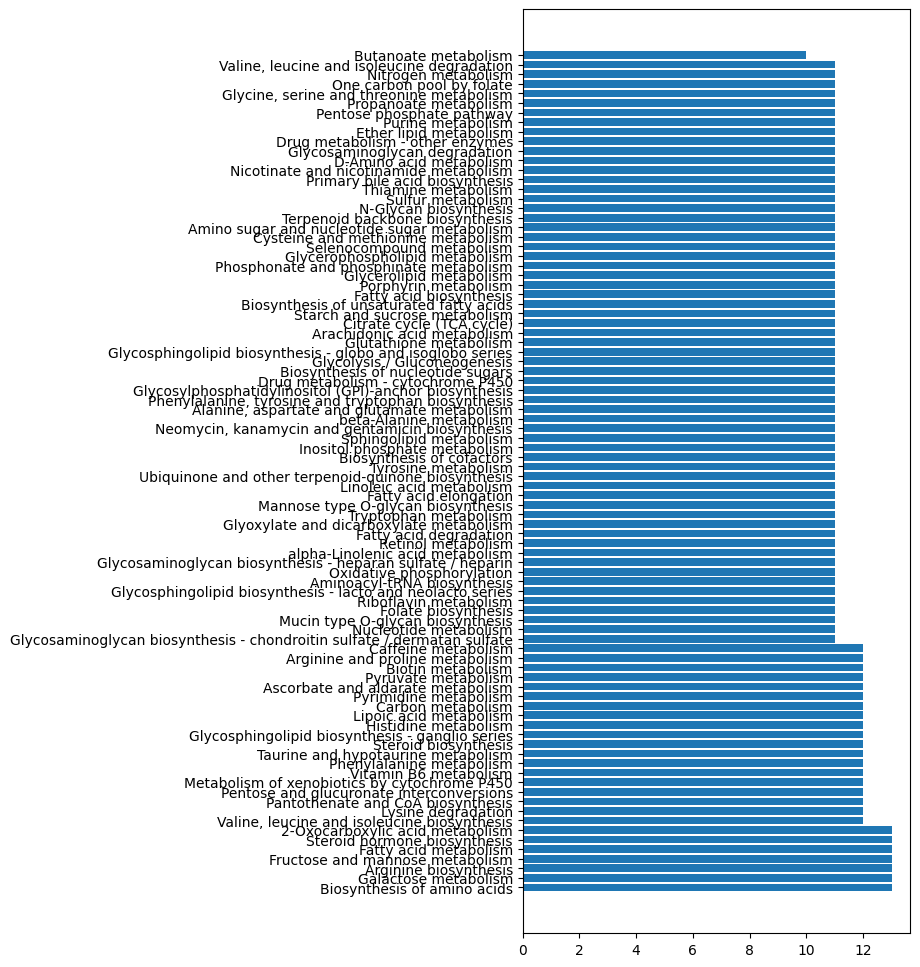

In [75]:
fig, ax1 = plt.subplots(figsize=(5,12))
ax1.barh(vc.keys(), vc.values())
#ax1.tick_params(axis='x', labelrotation=90)

In [76]:
pvc = {}
for i in keggdf.index:
    name = keggdf.loc[i, 'name']
    if name in vc :
        pvc[i] = vc[name]
    else :
        pvc[i] = 0
pvc = pd.DataFrame.from_dict(pvc, orient='index', columns=['count'])
pvc.to_csv('dataset/pathway_vc.csv', index_label='pathway_code')